In [1]:
%load_ext autoreload
%autoreload 2

import json
import re
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
from time import time, sleep

from utils import *
from jigsaws_utils import *
from custom_pca import custom_pca
from video_loader import VideoLoader
from autoencoders import *

seed = 42

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('Device:',torch.cuda.get_device_name(device))

Device: Tesla P100-PCIE-12GB


## Comparison of reconstruction error between models

For one video and one gesture plot the reconstruction of each frame with respect to the models during the video to see how the models adapt to the others.

In [2]:
ncomp = 10

task = 2 # Suturing
task_name = i2task[task]
subject = 'B'
trial = 1
capt = 1
gesture = 3 # Pushing needle through tissue

video_filename = f'{root_path}/{task_name}/video/{task_name}_{subject}00{trial}_capture{capt}.avi'
full_video = VideoLoader(video_filename, gray=True, torch=False)
fragments, _ = load_video_data(tasks=task, subjects=subject, trials=trial, captures=capt, gestures=gesture)
print(f'Number of instances of gesture {gi2descr[gesture]} in the video:',len(fragments))

Number of instances of gesture Pushing needle through tissue in the video: 7


### Using baseline

Models from same gesture: $M_i = (C_i, A_i)$

Plot for each frame $y_t$: $||y_t - C_i(A_iC_i^T(y_{t-1}))||$

In [3]:
models_baseline = []
errors_baseline = []
nfrag_show = 4

for video in fragments[:nfrag_show]:
    # Fit the model
    video.torch = False
    all_frames = video.get_all_frames().reshape(video.duration_frames, -1)

    compression_model = custom_pca(ncomp)
    compression_model.fit(all_frames)
    frames_enc, shape = compression_model.encode(all_frames)
    A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]

    models_baseline.append((compression_model, A))

    # Compute the reconstruction errors
    all_frames = full_video.get_all_frames().reshape(full_video.duration_frames, -1)
    all_frames_pred = compression_model.decode(compression_model.encode(all_frames)[0] @ A)
    all_frames_pred = np.clip(all_frames_pred, 0, 255)
    errors_baseline.append(np.sqrt(np.mean((all_frames[1:] - all_frames_pred[:-1])**2, axis=1)))

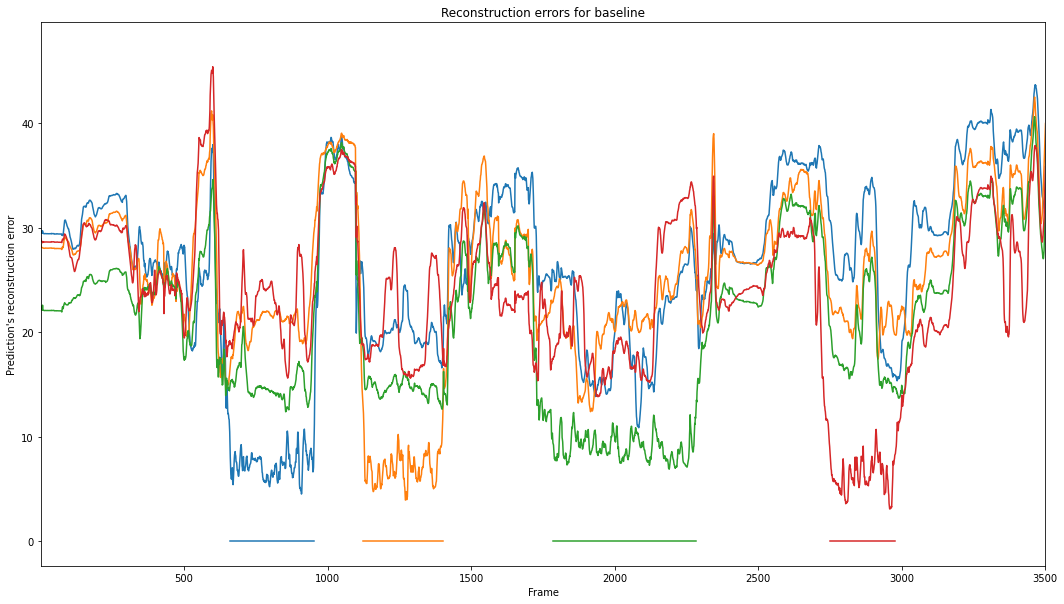

In [6]:
colors = [f'C{d}' for d in [0, 1, 2, 3, 4, 6, 8, 9]]
plt.figure(figsize=(18, 10))
plt.title('Reconstruction errors for baseline')
plt.xlabel('Frame')
plt.ylabel("Prediction's reconstruction error")
xlim = 3500
plt.xlim(1, xlim)

for i, fragment in enumerate(fragments[:nfrag_show]):
    duration = fragment.duration_frames
    start, end = fragment.start_frame, fragment.start_frame + duration
    plt.plot(np.arange(start, end), duration*[0], colors[i])

for i in range(nfrag_show):
    plt.plot(np.arange(1, full_video.duration_frames), errors_baseline[i], colors[i])

### Using baseline, normalizing the transition matrix

Models from same gesture: $\tilde{M_i} = (C_i, \tilde{A_i})$

Plot for each frame $y_t$:   $||y_t - C_i(\tilde{A_i}C_i^T(y_{t-1}))||$

In [4]:
models_baseline_stable = [(a, 0.98*b/np.linalg.norm(b, ord=2)) for a, b in models_baseline]
errors_baseline_stable = []
for i, (compression_model, A) in enumerate(models_baseline_stable[:nfrag_show]):
    full_video.torch = False
    all_frames = full_video.get_all_frames().reshape(full_video.duration_frames, -1)

    all_frames_pred = compression_model.decode(compression_model.encode(all_frames)[0] @ A)
    all_frames_pred = np.clip(all_frames_pred, 0, 255)
    errors_baseline_stable.append(np.sqrt(np.mean((all_frames[1:] - all_frames_pred[:-1])**2, axis=1)))

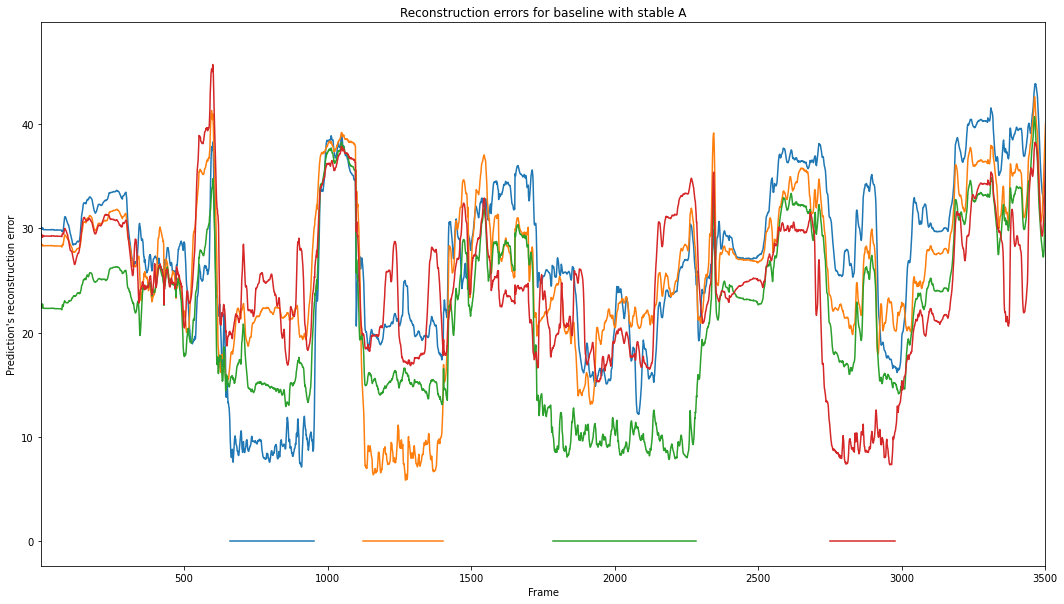

In [12]:
colors = [f'C{d}' for d in [0, 1, 2, 3, 4, 6, 8, 9]]
plt.figure(figsize=(18, 10))
plt.title('Reconstruction errors for baseline with stable A')
plt.xlabel('Frame')
plt.ylabel("Prediction's reconstruction error")
plt.xlim(1, xlim)

for i, fragment in enumerate(fragments[:nfrag_show]):
    duration = fragment.duration_frames
    start, end = fragment.start_frame, fragment.start_frame + duration
    plt.plot(np.arange(start, end), duration*[0], colors[i])

for i in range(nfrag_show):
    plt.plot(np.arange(1, full_video.duration_frames), errors_baseline_stable[i], colors[i])

### Using baseline, normalizing the transition matrix and enforcing the models to create clusters

2 Models from same gesture: $\tilde{M_i} = (C_i, \tilde{A_i})$

Optimize $\tilde{A_2}$ (model in orange) by minimizing the martin distance between $\tilde{A_1}$ and $\tilde{A_2}$. Each time the $\tilde{A_2}$ is modified, plot:

$y_t$: $||y_t - C_1(\tilde{A_1}C_1^T(y_{t-1}))||$

$y_t$: $||y_t - C_2(\hat{A_2}C_2^T(y_{t-1}))||$

With $$\hat{A_2}=\tilde{A_2}-\alpha \frac{\partial d_M^2(M_1, M2)}{\partial \tilde{A_2}}$$ 

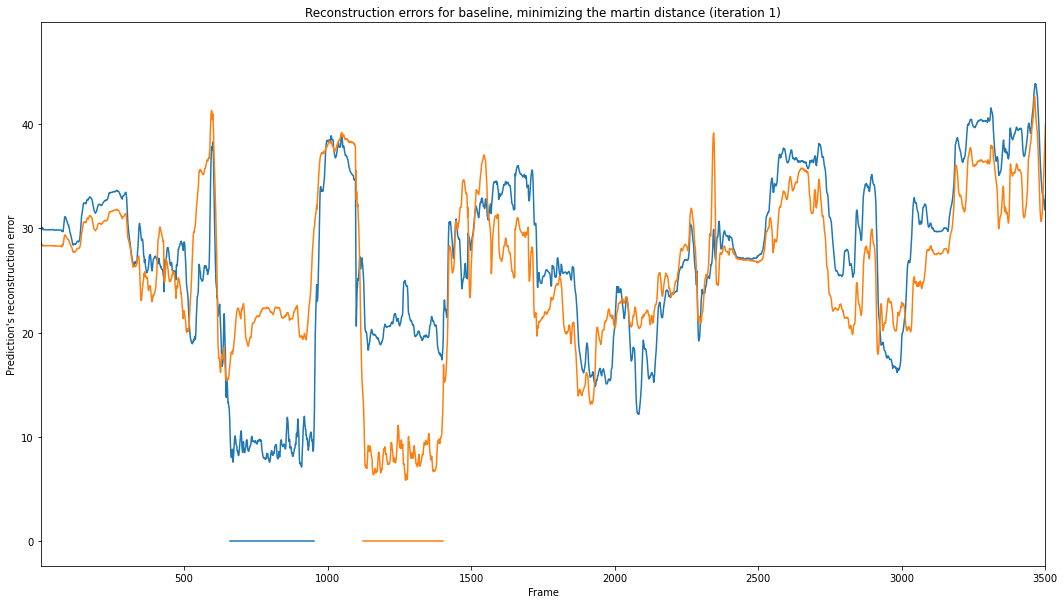

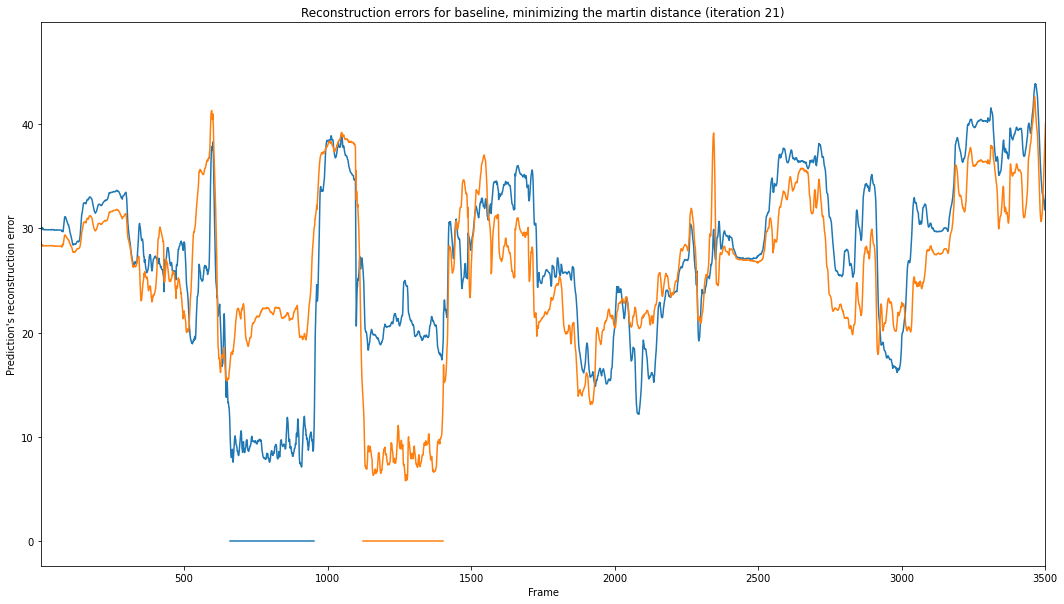

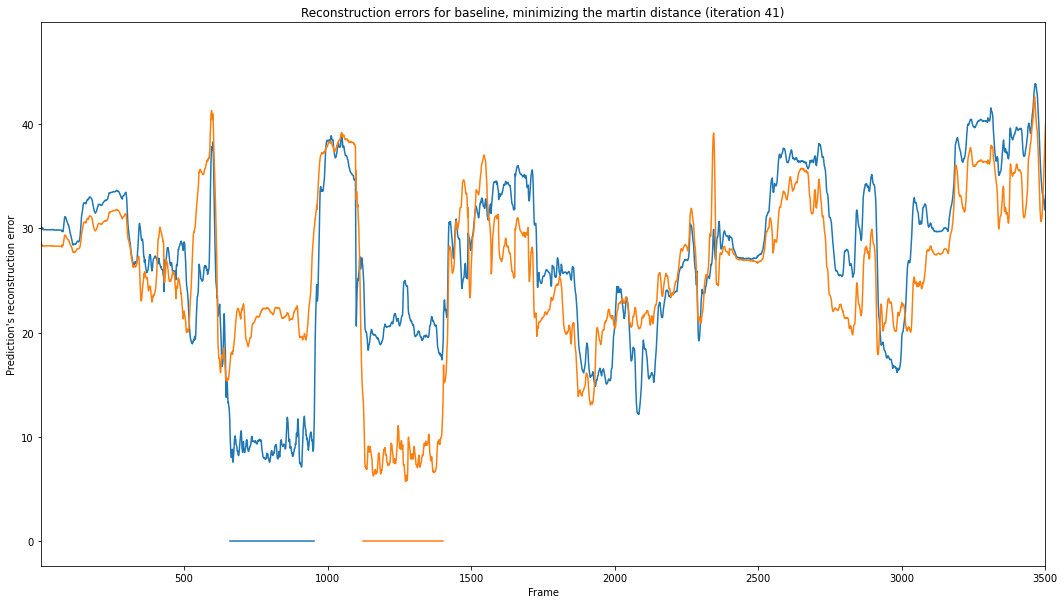

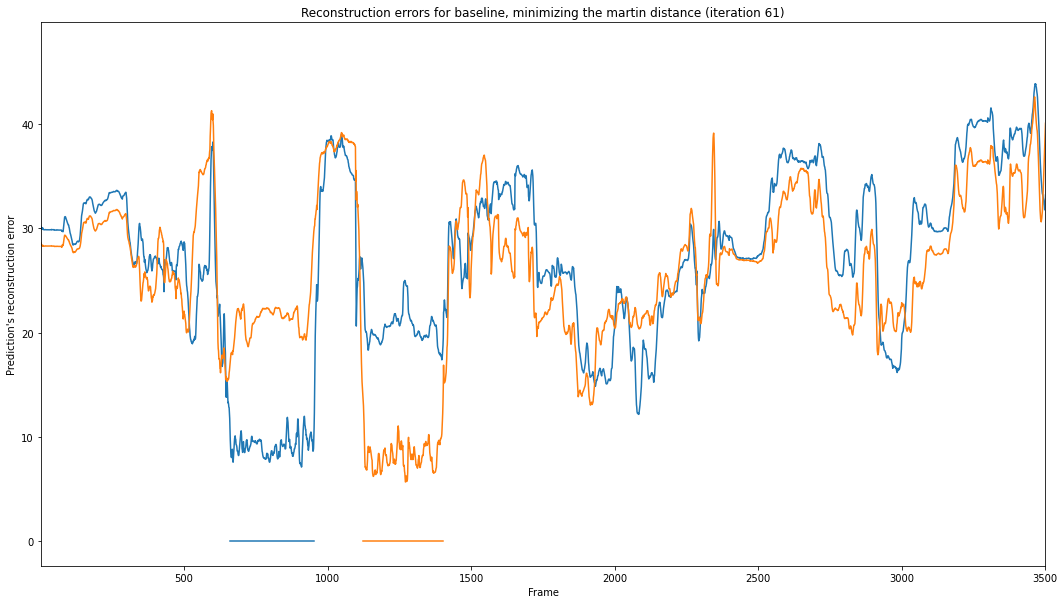

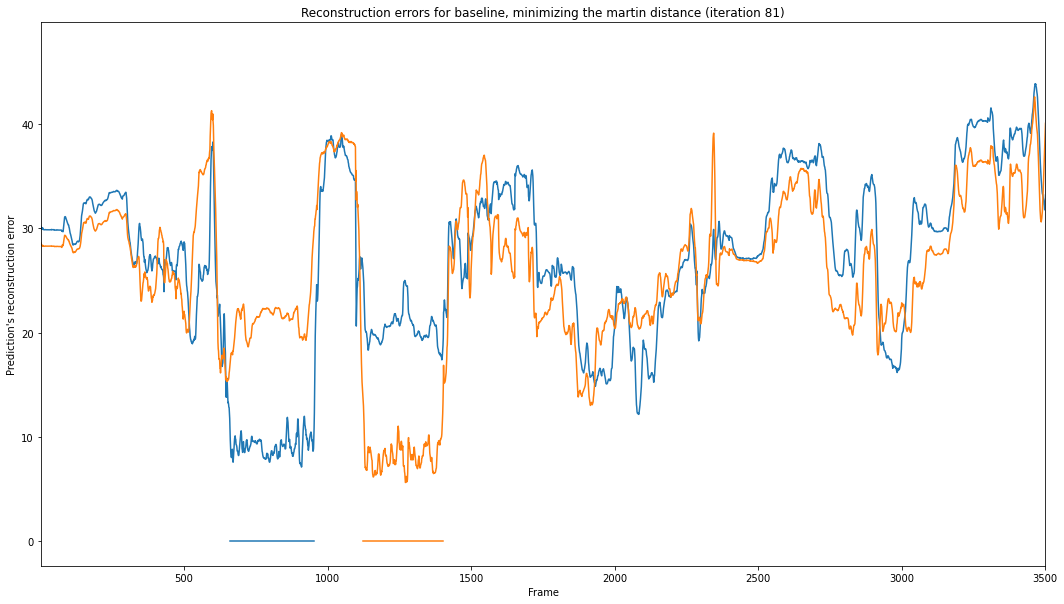

In [9]:
A1, A2 = models_baseline_stable[0][1], models_baseline_stable[1][1]
models_martin_minimization = models_baseline_stable[:2]

num_iteration_martin = 100
martin_dists = np.zeros(num_iteration_martin)
for i in range(num_iteration_martin):
    A2 = A2 - 0.00001*grad_martin_dist(A1, A2)
    models_martin_minimization[1] = models_martin_minimization[1][0], A2
    martin_dists[i] = martin_dist(*models_martin_minimization)
    if (i % 20) != 0:
        continue

    colors = [f'C{d}' for d in [0, 1, 2, 3, 4, 6, 8, 9]]
    plt.figure(figsize=(18, 10))
    plt.title('Reconstruction errors for baseline, minimizing the martin distance (iteration %s)' % (i+1))
    plt.xlabel('Frame')
    plt.ylabel("Prediction's reconstruction error")
    plt.xlim(1, xlim)
    # Plot gesture's window on plot
    for i, fragment in enumerate(fragments[:2]):
        duration = fragment.duration_frames
        start, end = fragment.start_frame, fragment.start_frame + duration
        plt.plot(np.arange(start, end), duration*[0], colors[i])

    # Plot reconstruction errors
    for i, (compression_model, A2) in enumerate(models_martin_minimization):
        full_video.torch = False
        all_frames = full_video.get_all_frames().reshape(full_video.duration_frames, -1)

        all_frames_pred = compression_model.decode(compression_model.encode(all_frames)[0] @ A2)
        all_frames_pred = np.clip(all_frames_pred, 0, 255)
        errors = np.sqrt(np.mean((all_frames[1:] - all_frames_pred[:-1])**2, axis=1))
        plt.plot(np.arange(1, full_video.duration_frames), errors, colors[i])
    plt.show()

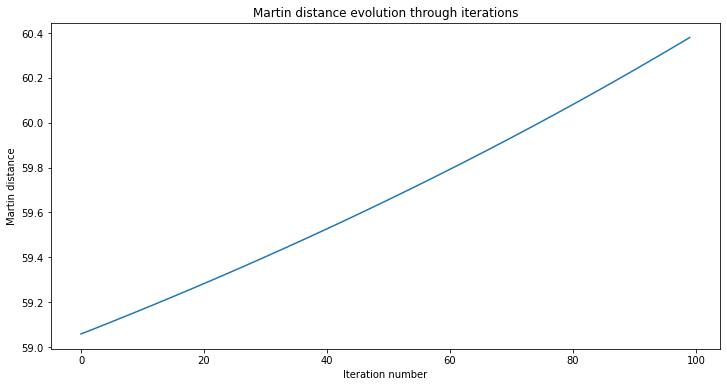

In [12]:
plt.figure(figsize=(12, 6))
plt.title('Martin distance evolution through iterations')
plt.ylabel('Martin distance')
plt.xlabel('Iteration number')
_ = plt.plot(np.arange(num_iteration_martin), martin_dists)